# Generating Mosaics and Calculating Medians with DataCube

In this tutorial, we will learn how to generate mosaics and compute temporal and geometric medians using DataCube. We will work with satellite imagery, apply masks to remove clouds and shadows, and finally export the results to GeoTIFF files.

## Table of Contents

1. Importing Required Libraries
2. Installing Necessary Packages
3. Environment Setup and Dask Cluster Configuration
4. Defining the Region of Interest and Time Range
5. Defining the Bands to Process
6. Defining the Query and Loading Data
7. Cloud and Shadow Masking
8. Calculating the Temporal Median
9. Visualizing Results
10. Exporting Results to GeoTIFF Files
11. Merging Bands into a Multiband File
12. Calculating the Geometric Median (Optional)
13. Calculating NDVI and Statistical Measures


## 1. Importing Required Libraries

We begin by importing all the necessary libraries that will be used throughout this tutorial.

In [26]:
import sys
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import subprocess
import numpy as np
import xarray as xr
import dask
import dask.array as da
from random import randint
from datetime import datetime

import datacube
import rasterio
import odc
from odc.algo import int_geomedian, to_f32
from datacube.utils.cog import write_cog
from IPython.display import display
from shapely.geometry import Polygon
import xarray as xr
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb

These libraries include:

- **datacube**: For accessing and managing Earth observation data.
- **dask**: For parallel computing and handling large datasets.
- **numpy** and **xarray**: For numerical operations and handling multi-dimensional arrays.
- **rasterio**: For reading and writing raster datasets.
- **odc.algo**: Contains advanced algorithms for processing data cubes.
- **shapely**: For manipulating geometric objects.
- **deafrica_tools**: Provides tools for working with Digital Earth Africa data.

---

## 2. Installing Necessary Packages

We ensure that the required packages `numpy` and `hdstats` are installed. The `--force-reinstall` flag ensures that the latest versions are installed, which can resolve potential conflicts.

In [ ]:
!pip install --force-reinstall numpy hdstats

In [ ]:
!pip install rioxarray

---

## 3. Environment Setup and Dask Cluster Configuration

We create a local Dask cluster to parallelize operations and optimize performance. This is especially useful when working with large datasets.

In [ ]:
create_local_dask_cluster()
dc = datacube.Datacube(app="Generate_Mosaics")

- **create_local_dask_cluster()**: Sets up a local Dask cluster for parallel processing.
- **datacube.Datacube(app="Generate_Mosaics")**: Initializes the DataCube instance with the application name "Generate_Mosaics".

This will output information about the Dask client and cluster, which helps in monitoring computational resources.

---

## 4. Defining the Region of Interest and Time Range

We specify the temporal and spatial range of our study area. This defines the subset of data we are interested in.

In [3]:
# Define time range for the year 2022
time_range = ("2022-01-01", "2022-12-31")

# Define longitude and latitude ranges (Trinidad and Tobago area)
lon_range = (-61.31, -61.25)
lat_range = (10.6, 10.66)

- **time_range**: Specifies the period for which we want to retrieve data.
- **lon_range** and **lat_range**: Define the geographical boundaries of our area of interest.

---

## 5. Defining the Bands to Process

We select the spectral bands that we will use in our analysis. These bands cover various parts of the electromagnetic spectrum and are useful for different types of analyses.

In [4]:
# Define the bands to be processed
bands = [
    'coastal_aerosol', 'blue', 'green', 'red', 'veg5', 'veg6', 'veg7',
    'nir', 'narrow_nir', 'water_vapour', 'swir1', 'swir2', 'slc'
]

- **'slc'**: Scene Classification Layer, useful for masking clouds and shadows.
- **Other bands**: Represent different wavelengths and are used for various analyses like vegetation indices.

---

## 6. Defining the Query and Loading Data

We create a query that will be used to load data from the DataCube and then load the available datasets.

In [ ]:
# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': bands,
    'resolution': (10, -10),  # Spatial resolution in meters
    'output_crs': 'EPSG:32620'  # UTM Zone 20N for Trinidad and Tobago
}

# Find available datasets
datasets = dc.find_datasets(product="s2_ard_scene")

# Load the data using the query
ds = dc.load(datasets=datasets, **query)


# Check if data was loaded
if ds:
    print(ds)
else:
    print("No data available for the given query.")

Explanation:

- **dc.find_datasets()**: Searches for datasets in the specified product.
- **dc.load()**: Loads the datasets into an xarray Dataset, applying the query parameters.

---

## 7. Cloud and Shadow Masking

We apply masking to remove clouds and shadows from the images. This step is crucial for accurate analysis as clouds and shadows can obscure the Earth's surface.

In [10]:
# Create a mask for unwanted categories
mask = odc.algo.enum_to_bool(
    ds['slc'], 
    categories=[
                    'Cloud shadows',  
                    #'Saturated or defective pixel', 
                    'Thin cirrus', 
                    #'Dark features / Shadows', 
                    'Cloud medium probability', 
                    'cloud high probability', 
                    'Unclassified',  
    ]
)
# Apply the mask to the dataset
ds = odc.algo.erase_bad(ds, where=mask)  

Explanation:

- **ds['slc']**: Accesses the Scene Classification Layer, which labels each pixel.
- **odc.algo.enum_to_bool()**: Converts the specified categories into a boolean mask.
- **categories**: List of classification categories to mask out.
- **odc.algo.erase_bad()**: Applies the mask to the dataset, setting masked pixels to `NaN`.

---

## 8. Calculating the Temporal Median

We define functions to calculate the temporal median efficiently and then perform the calculation. The temporal median reduces the impact of outliers and provides a cloud-free composite.

In [7]:
def int_median_np(band, nodata=None, **kw):
    """
    Efficient calculation of the temporal median using NumPy,
    utilizing all images without discarding any.

    Parameters:
    band (np.array): Array with dimensions (time, y, x)
    nodata: Value to treat as nodata (optional)
    **kw: Additional keyword arguments
    Returns:
    np.array: Calculated median with dimensions (y, x)
    """
    nt, ny, nx = band.shape

    # Replace nodata values with np.nan
    if nodata is not None:
        band = np.where(band == nodata, np.nan, band)

    # Calculate the median ignoring np.nan values
    median = np.nanmedian(band, axis=0)

    return median

def int_median(ds, **kw):
    """
    Calculate the temporal median for each band in an xarray Dataset,
    using all images in the time dimension.

    Parameters:
    ds (xarray.Dataset): Dataset with dimensions (time, y, x)
    **kw: Additional keyword arguments
    Returns:
    xarray.Dataset: Dataset with the median calculated for each band
    """
    is_dask = dask.is_dask_collection(ds)
    ds_out = xr.Dataset()

    # Calculate the median for each band individually
    for band_name, band_data in ds.data_vars.items():
        nodata = getattr(band_data, 'nodata', -9999)  # Get the nodata value
        if is_dask:
            data = da.map_blocks(int_median_np, band_data.data, nodata=nodata,
                                 dtype=band_data.dtype, **kw)
        else:
            data = int_median_np(band_data.data, nodata=nodata, **kw)

        # Add the resulting band to the output dataset
        ds_out[band_name] = xr.DataArray(
            data,
            dims=("y", "x"),
            coords={"y": band_data.coords["y"], "x": band_data.coords["x"]}
        )
        ds_out[band_name].attrs.update(band_data.attrs)

    return ds_out

Explanation:

- **int_median_np()**: Computes the median across the time dimension for a single band using NumPy.
- **int_median()**: Applies `int_median_np()` to each band in the Dataset.
- **da.map_blocks()**: Allows for chunk-wise operations with Dask.

We then compute the median and measure the time taken.

In [11]:
# Record the start time
start_time = datetime.now()
print("Starting temporal median calculation:", start_time)

# Calculate the temporal median
median = int_median(ds).compute()

# Record the end time
end_time = datetime.now()
print("Finished temporal median calculation:", end_time)
print("Total time:", end_time - start_time)

Starting temporal median calculation: 2024-10-02 17:34:44.859252
Finished temporal median calculation: 2024-10-02 17:35:01.394827
Total time: 0:00:16.535575


---

## 9. Visualizing Results

We visualize the calculated median using an RGB representation. This helps in assessing the quality of the median composite.

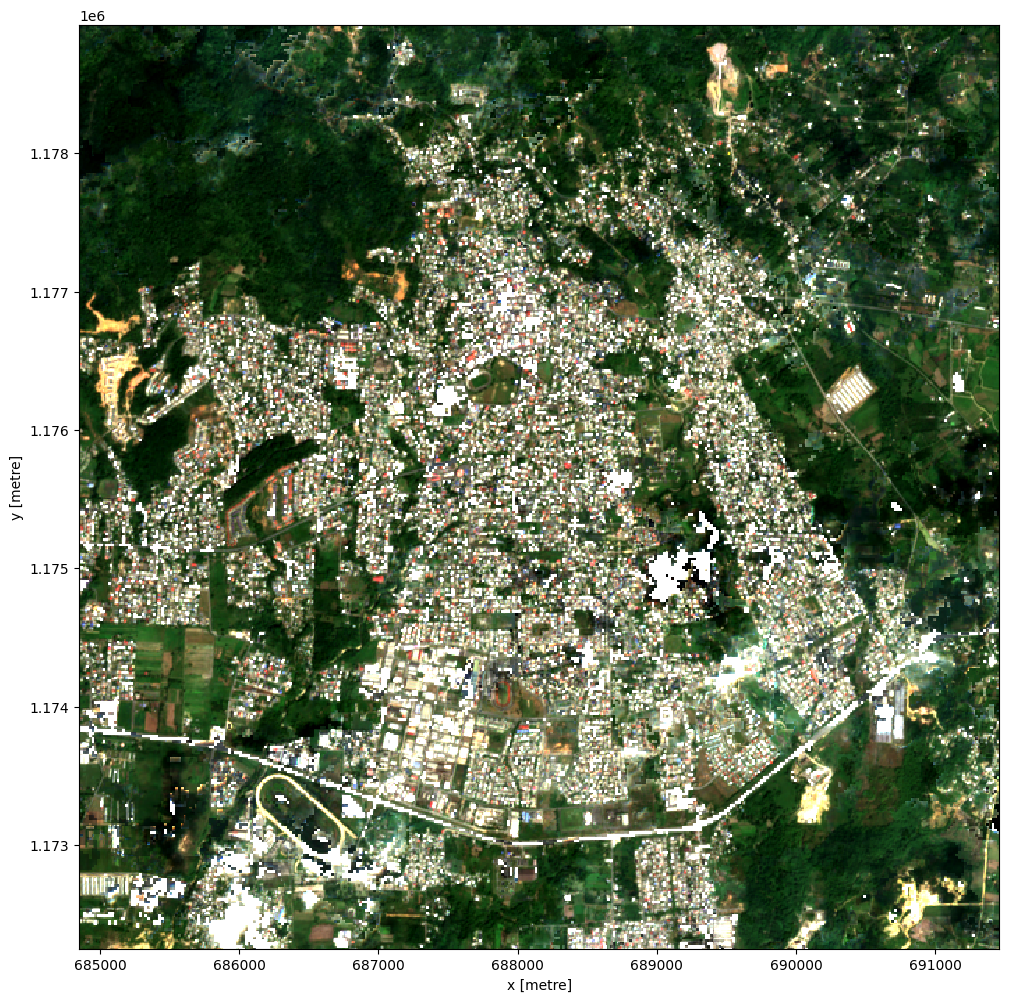

In [13]:
# Visualize the temporal median
rgb(median, size=12)

Explanation:

- **rgb()**: A function from `deafrica_tools.plotting` that displays an RGB composite of the dataset.
- **median**: The Dataset containing the median values.
- **size**: Specifies the size of the plot.

## 10. Exporting Results to GeoTIFF Files

We define the output path and export each band of the median to GeoTIFF files. This allows us to use the results in GIS software or for further analysis.

In [14]:
# Define output path and period
path = 'ODC-PRODUCTS-MEDIAN/2022/'
period = '2022'

# Create the directory if it doesn't exist
os.makedirs(path, exist_ok=True)

Exporting each band using the `write_cog` function:

In [15]:
# Export each band to GeoTIFF files
write_cog(median.coastal_aerosol, f'{path}gm_01_coastal_aerosol_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.blue, f'{path}gm_02_blue_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.green, f'{path}gm_03_green_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.red, f'{path}gm_04_red_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.veg5, f'{path}gm_05_veg5_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.veg6, f'{path}gm_06_veg6_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.veg7, f'{path}gm_07_veg7_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.nir, f'{path}gm_08_nir_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.narrow_nir, f'{path}gm_09_narrow_nir_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.water_vapour, f'{path}gm_10_water_vapour_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.swir1, f'{path}gm_11_swir1_{period}_tto_quality_median.tif', nodata=-9999)
write_cog(median.swir2, f'{path}gm_12_swir2_{period}_tto_quality_median.tif', nodata=-9999)

PosixPath('ODC-PRODUCTS-MEDIAN/2022/gm_12_swir2_2022_tto_quality_median.tif')

Explanation:

- **write_cog()**: Writes a Cloud Optimized GeoTIFF (COG) file from a DataArray.
- **nodata=-9999**: Specifies the nodata value in the output file.

## 11. Merging Bands into a Multiband File

We define a function to merge multiple GeoTIFF files into a single multiband file. This is useful for creating a single file that contains all bands, which is convenient for some applications.

In [16]:
import rasterio

def merge_tifs_to_multiband(file_list, output_file):
    """
    Merges multiple TIF files into a single multiband file.

    Parameters:
    file_list (list): List of paths to the TIF files to be merged.
    output_file (str): Path where the multiband output file will be saved.
    """
    # Open the files and read the bands
    src_files_to_mosaic = []
    for file in file_list:
        src = rasterio.open(file)
        src_files_to_mosaic.append(src)

    # Define the output profile (taking the profile from the first file)
    profile = src_files_to_mosaic[0].profile
    profile.update(count=len(src_files_to_mosaic))  # Update the number of bands

    # Write the multiband file
    with rasterio.open(output_file, 'w', **profile) as dst:
        for idx, src in enumerate(src_files_to_mosaic, start=1):
            dst.write(src.read(1), idx)  # Write each band into the multiband file

    # Close the files
    for src in src_files_to_mosaic:
        src.close()

    print(f"Multiband file saved at {output_file}")

Specify the list of files to merge and execute the function:

In [17]:
# List of files to merge
files_to_merge = [
    f"{path}gm_01_coastal_aerosol_{period}_tto_quality_median.tif",
    f"{path}gm_02_blue_{period}_tto_quality_median.tif",
    f"{path}gm_03_green_{period}_tto_quality_median.tif",
    f"{path}gm_04_red_{period}_tto_quality_median.tif",
    f"{path}gm_05_veg5_{period}_tto_quality_median.tif",
    f"{path}gm_06_veg6_{period}_tto_quality_median.tif",
    f"{path}gm_07_veg7_{period}_tto_quality_median.tif",
    f"{path}gm_08_nir_{period}_tto_quality_median.tif",
    f"{path}gm_09_narrow_nir_{period}_tto_quality_median.tif",
    f"{path}gm_10_water_vapour_{period}_tto_quality_median.tif",
    f"{path}gm_11_swir1_{period}_tto_quality_median.tif",
    f"{path}gm_12_swir2_{period}_tto_quality_median.tif"
]

# Name of the output file
output_file = f"{path}GM_{period}_TTO_quality_median.tif"

# Execute the merge
merge_tifs_to_multiband(files_to_merge, output_file)

Multiband file saved at ODC-PRODUCTS-MEDIAN/2022/GM_2022_TTO_quality_median.tif


## 12. Calculating the Geometric Median (Optional)

As an optional step, we can calculate the geometric median using the `int_geomedian` function from `odc.algo` and visualize the result. The geometric median is less sensitive to outliers compared to the arithmetic median.

In [30]:
# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': bands,
    'resolution': (10, -10),  # Spatial resolution in meters
    'output_crs': 'EPSG:32620'  # UTM Zone 20N for Trinidad and Tobago
}

# Find available datasets
datasets = dc.find_datasets(product="s2_ard_scene")

# Load the data using the query
ds = dc.load(datasets=datasets, **query)


# Check if data was loaded
if ds:
    print(ds)
else:
    print("No data available for the given query.")

<xarray.Dataset>
Dimensions:          (time: 73, x: 661, y: 668)
Coordinates:
  * time             (time) datetime64[ns] 2022-01-03T14:42:09.500000 ... 202...
  * y                (y) float64 1.172e+06 1.172e+06 ... 1.179e+06 1.179e+06
  * x                (x) float64 6.915e+05 6.914e+05 ... 6.849e+05 6.849e+05
    spatial_ref      int32 32620
Data variables:
    coastal_aerosol  (time, y, x) int16 613 613 661 661 ... 1568 1568 1568 1568
    blue             (time, y, x) int16 1200 1219 1089 946 ... 1983 1963 1955
    green            (time, y, x) int16 1369 1526 1514 1374 ... 2049 2111 2149
    red              (time, y, x) int16 1277 1421 1439 1151 ... 1679 1693 1762
    veg5             (time, y, x) int16 1769 1769 1805 1805 ... 1741 1741 1921
    veg6             (time, y, x) int16 3295 3295 3252 3252 ... 3557 3557 3872
    veg7             (time, y, x) int16 3636 3636 3569 3569 ... 4482 4482 4865
    nir              (time, y, x) int16 3311 3544 3631 3762 ... 5043 4941 5221
    na

In [31]:
# Create a mask for unwanted categories
mask = odc.algo.enum_to_bool(
    ds['slc'], 
    categories=[
                    'Cloud shadows',  
                    #'Saturated or defective pixel', 
                    'Thin cirrus', 
                    'Dark features / Shadows', 
                    'Cloud medium probability', 
                    'cloud high probability', 
                    #'Unclassified',  
    ]
)
# Apply the mask to the dataset
ds = odc.algo.erase_bad(ds, where=mask)  

In [32]:
# Record the start time
start_time = datetime.now()
print("Starting geometric median calculation:", start_time)

# Calculate the geometric median
geomedian = int_geomedian(ds).compute()

# Record the end time
end_time = datetime.now()
print("Finished geometric median calculation:", end_time)
print("Total time:", end_time - start_time)

Starting geometric median calculation: 2024-10-03 00:54:57.526382
Finished geometric median calculation: 2024-10-03 02:12:45.810398
Total time: 1:17:48.284016


Visualize the geometric median:

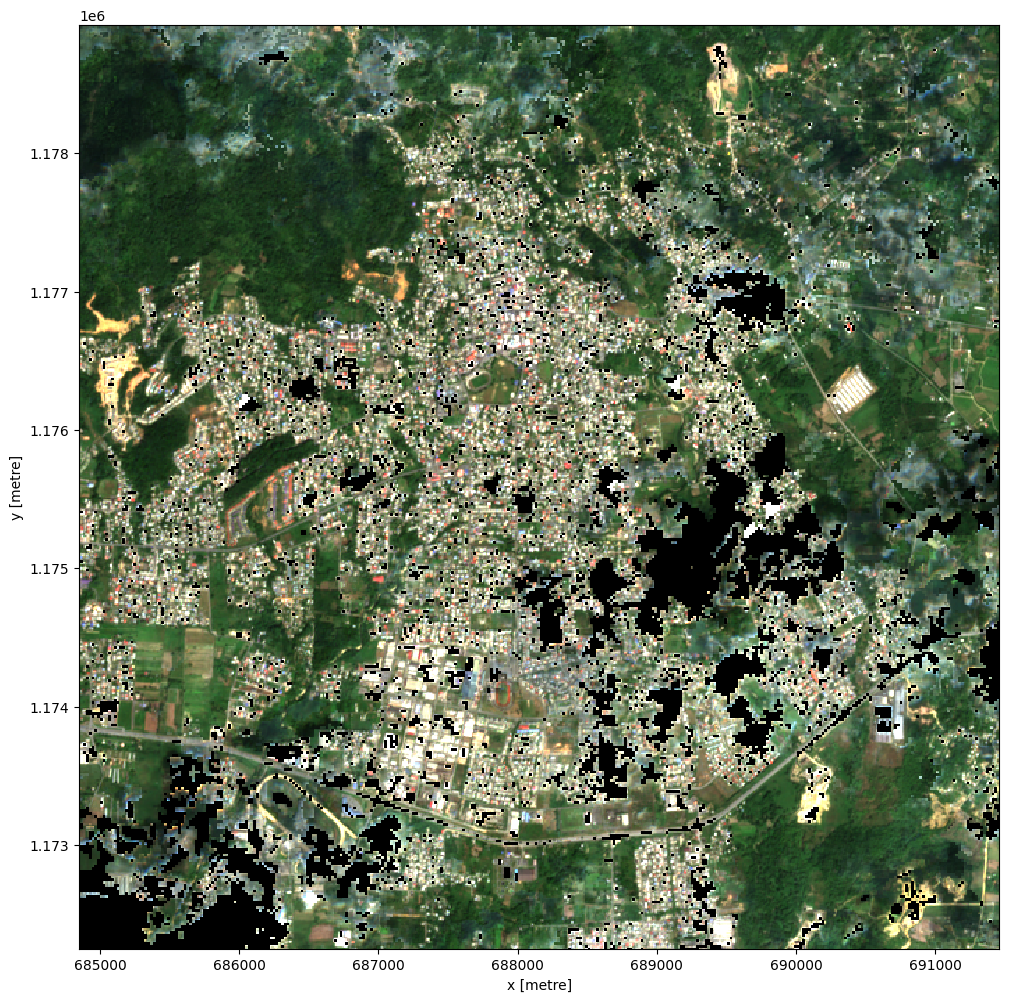

In [33]:
# Visualize the geometric median
rgb(geomedian, size=12)

## 13. Calculating NDVI and Statistical Measures

In this section, we will calculate the **Normalized Difference Vegetation Index (NDVI)** from our dataset and compute various statistical measures such as minimum, mean, maximum, standard deviation, and median over time. Finally, we will save the results to a GeoTIFF file for further analysis or visualization.

### 13.1 Calculating NDVI

The NDVI is a widely used index for assessing vegetation health and vigor. It is calculated using the Near-Infrared (NIR) and Red spectral bands according to the formula:

$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}$

In [35]:
import rioxarray  # Import rioxarray for raster operations

def process_ndvi(ds):
    print("Processing NDVI")
    ds = to_f32(ds)
    ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)
    return ndvi

# Calculate NDVI
ndvi = process_ndvi(ds)

Processing NDVI


**Explanation:**

- **`process_ndvi(ds)`**: A function that computes the NDVI using the NIR and Red bands from the dataset.
- **`to_f32(ds)`**: Converts the dataset to 32-bit floating point to ensure precision in calculations.
- **NDVI Calculation**: The formula `(ds.nir - ds.red) / (ds.nir + ds.red)` is applied to compute the NDVI for each pixel over time.
- **Return Value**: The function returns an xarray DataArray containing the NDVI values.

### 13.2 Computing Statistical Measures

We compute statistical measures over the time dimension to understand the temporal variability of NDVI throughout the period of interest.

In [36]:
def process_statistics(ndvi):
    print("Calculating statistics")
    xr_ds = []
    methods_names = ['min', 'mean', 'max', 'std', 'median']
    for method in methods_names:
        stat = getattr(ndvi, method)(dim='time', skipna=True)
        xr_ds.append(stat)
    return xr_ds

# Compute statistics
stats_list = process_statistics(ndvi)

Calculating statistics


**Explanation:**

- **`process_statistics(ndvi)`**: A function that calculates specified statistical measures on the NDVI DataArray.
- **Statistical Methods**: We compute the `min`, `mean`, `max`, `std` (standard deviation), and `median` of NDVI over time.
- **`getattr(ndvi, method)`**: Dynamically calls the statistical method on the NDVI DataArray.
- **`dim='time'`**: Specifies that the calculations are performed over the time dimension.
- **`skipna=True`**: Ensures that `NaN` values are ignored in the calculations.
- **Return Value**: The function returns a list of DataArrays, each representing one statistical measure.

### 13.3 Saving the Results to a GeoTIFF File

We save the computed statistical measures to a single multiband GeoTIFF file for easy visualization and further analysis.

In [37]:
def process_tif(stats_list, filename):
    print("Saving product")
    # Stack the stats along a new 'band' dimension
    xr_arr = xr.concat(stats_list, dim='band')
    # Assign names or indices to the 'band' dimension
    xr_arr = xr_arr.assign_coords(band=['min', 'mean', 'max', 'std', 'median'])
    # Ensure spatial dimensions are ordered correctly
    xr_arr = xr_arr.transpose('band', 'y', 'x')
    # Write to raster
    xr_arr.rio.write_crs(ds.geobox.crs).rio.to_raster(filename)

# Define the output path
output_path = "./stats_ndvi.tif"

# Save the statistics to a GeoTIFF file
process_tif(stats_list, output_path)

Saving product
